In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# В данном ноутбуке будет расмматриваться проблема прогнозирования конечной стоимости жилой недвижимости.

**Бизнес-контекст:**
- Для покупателей: избежать переплаты при покупке дома
- Для продавцов: справедливо оценить стоимость объекта  
- Для риелторов: точнее прогнозировать рыночную стоимость
- Для онлайн-платформ: повысить доверие к автоматическим оценкам

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

Загрузим необходимые библиотеки и откроем файл с данными

In [3]:
train_file_path = '/kaggle/input/house-prices-advanced-regression-techniques/train.csv'
dataset_df = pd.read_csv(train_file_path)
dataset_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [4]:
dataset_df = dataset_df.drop('Id', axis=1)
dataset_df.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [5]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

Начнём EDA с того, что отберем все непрерывные признаки.
После чего построим корреляционную матрицу (heatmap), чтобы выявить сильно коррелирующие пары признаков, иметь информацию для принятия будущих решений и выбора признаков для улучшения модели.

<Axes: >

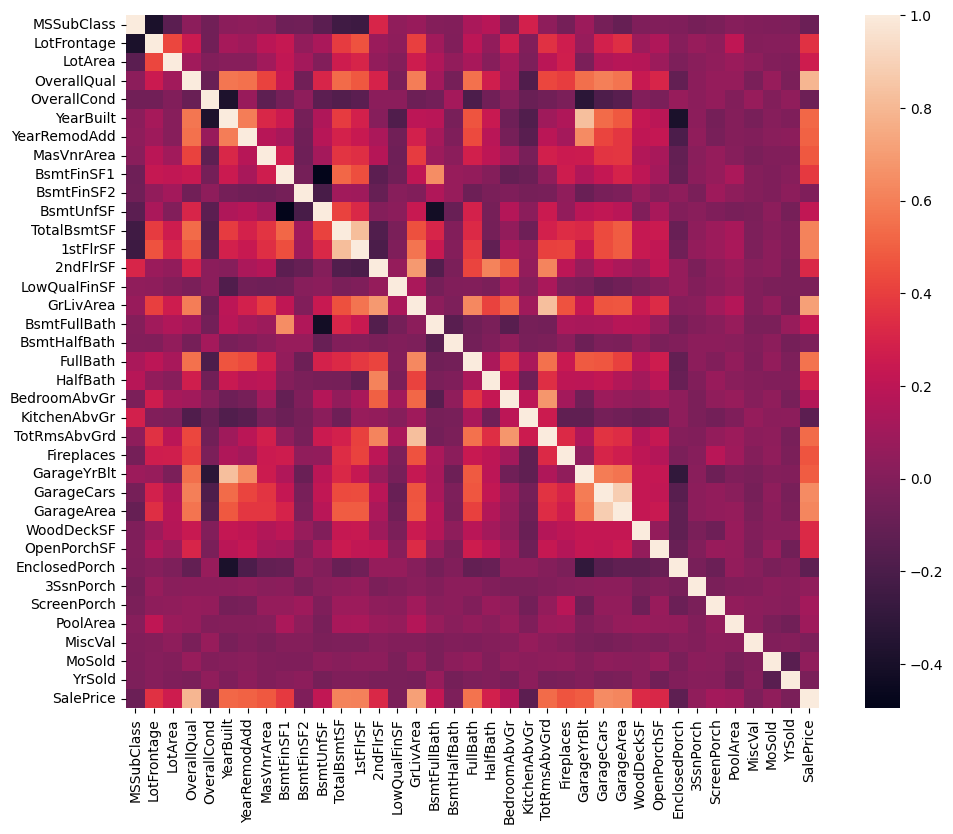

In [6]:
continuous_columns = [column for column in dataset_df.columns if dataset_df[column].dtype in ['int64', 'float64']]
cont_dataset_df = dataset_df[continuous_columns]
corr_map = cont_dataset_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr_map, square=True)

Выделим 9 признаков, которые сильнее всего коррелируют с таргетом и проанализируем их детальнее.

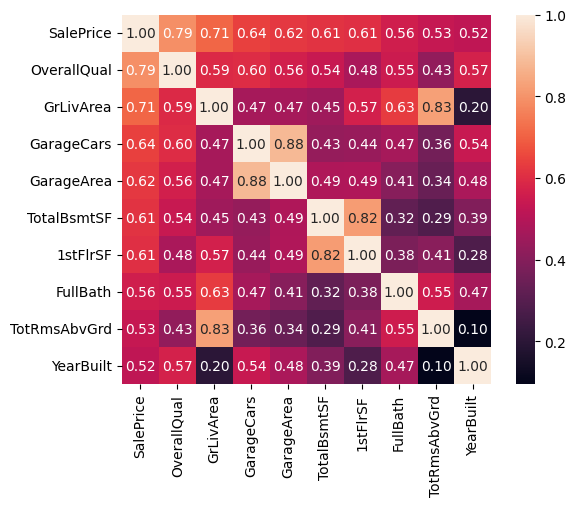

In [7]:
cols = corr_map.nlargest(10, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(cont_dataset_df[cols].values.T)
hm = sns.heatmap(cm, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Так как была выявлена мультиколлинеарность (>0.8) среди некоторых признаков, то уберем те признаки, которые меньше коррелируют с таргетом, а также выделим из них самые информативные и построим матрицу диаграмм рассеяния между парами признаков.

In [8]:
dataset_df = dataset_df.drop(['TotRmsAbvGrd', '1stFlrSF', 'GarageArea'], axis=1)

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

<function matplotlib.pyplot.show(close=None, block=None)>

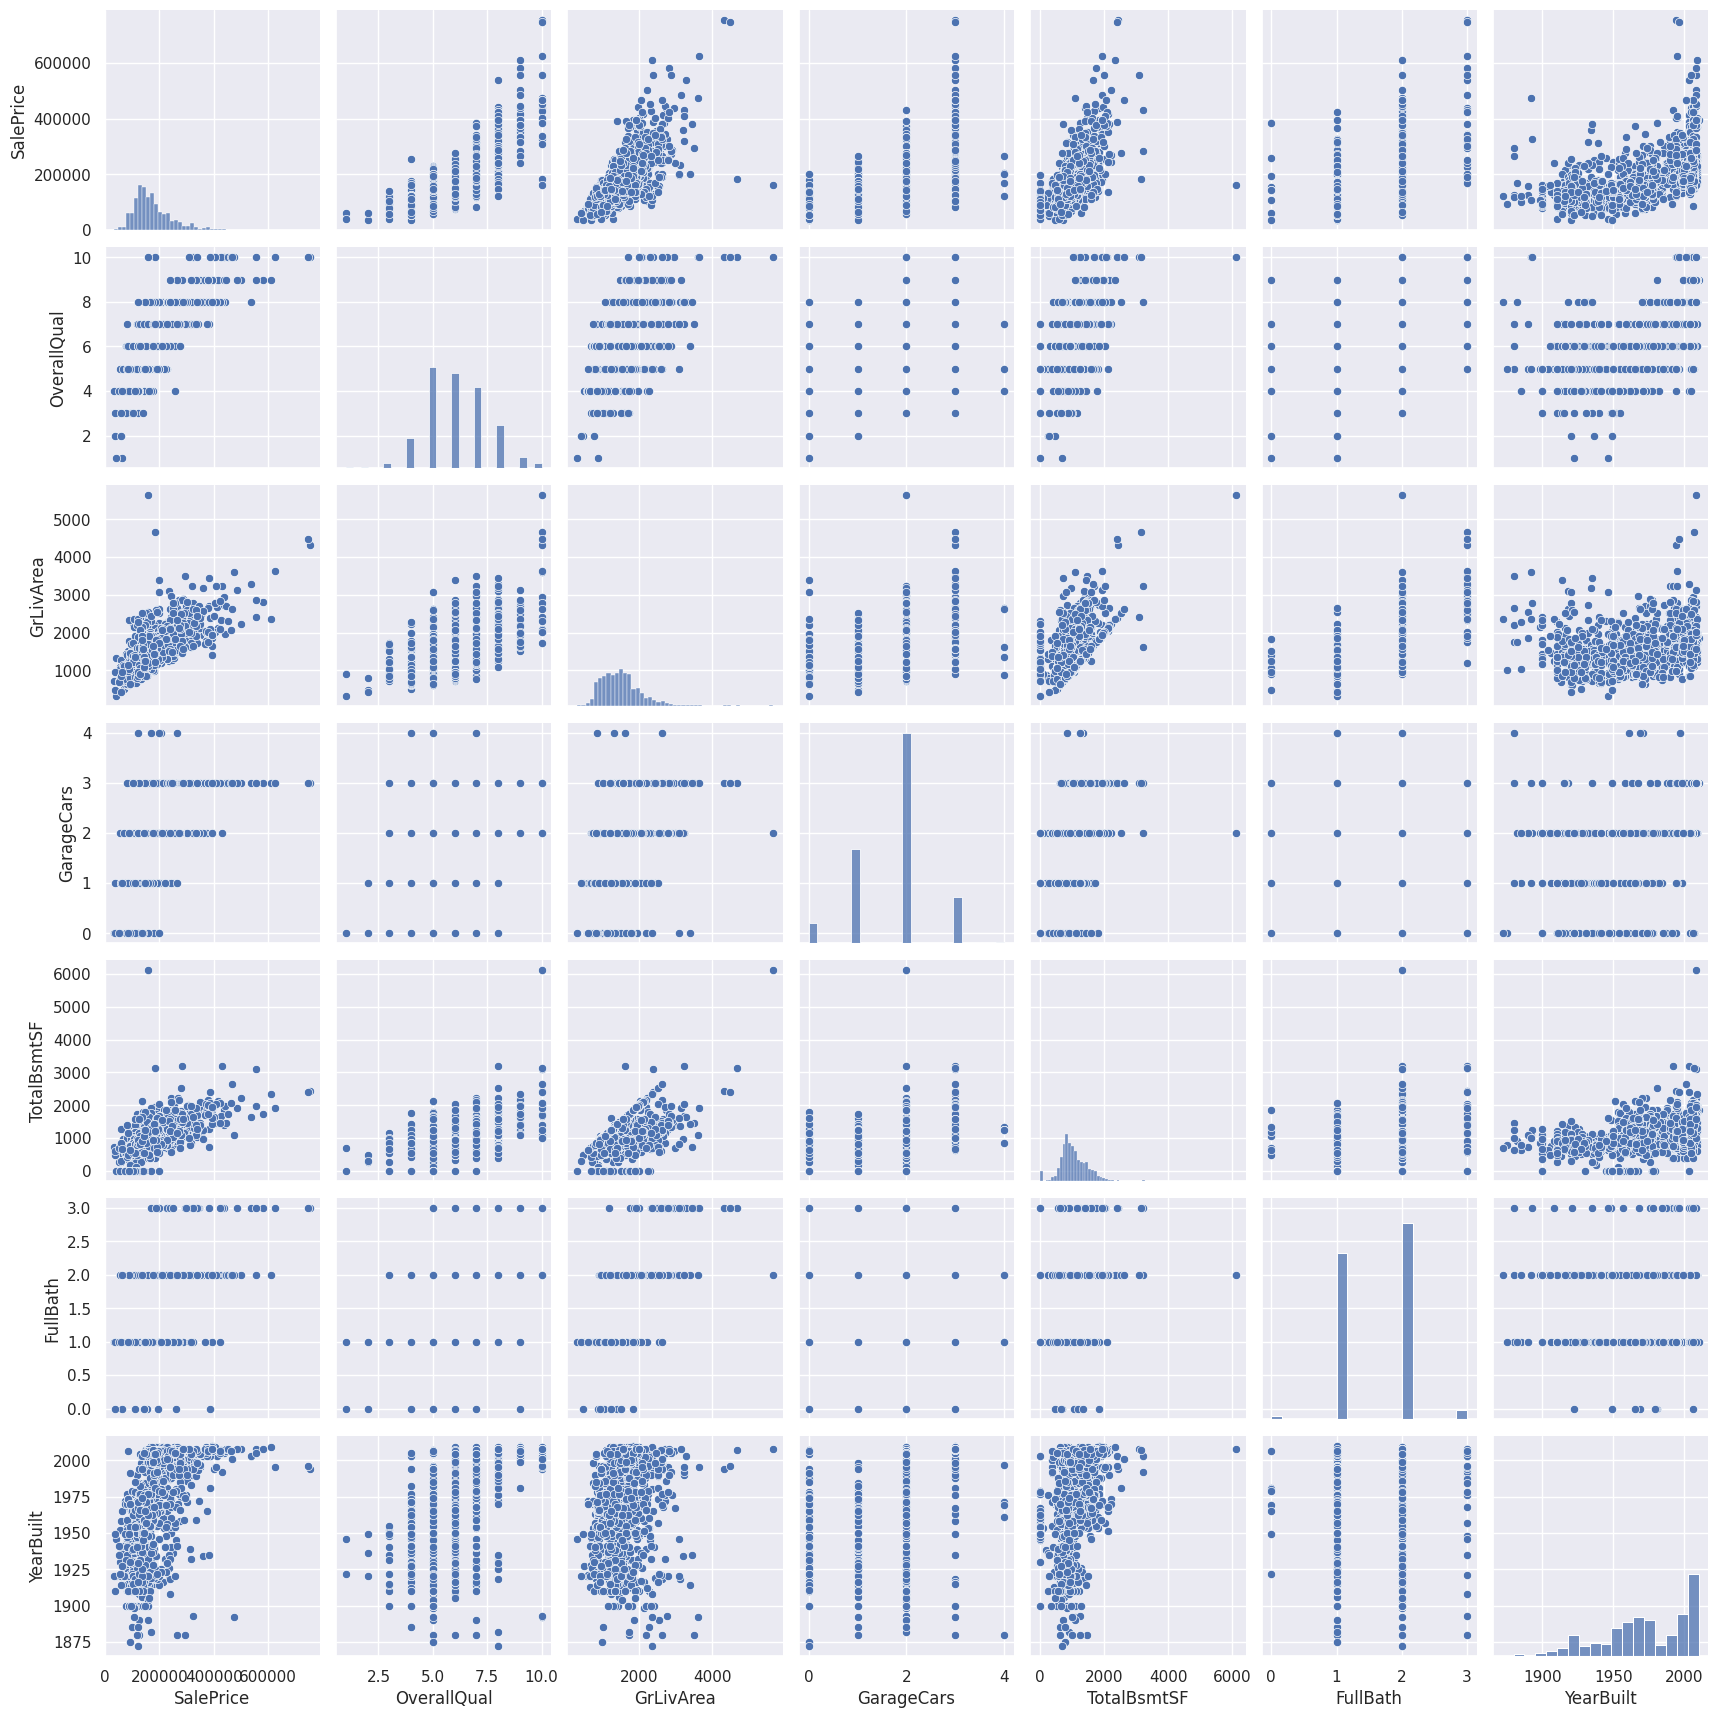

In [9]:
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(cont_dataset_df[cols])
plt.show

Теперь перейдём к очистке данных от пропусков, проанализируем их количество и процентное соотношение для каждого признака.

In [10]:
total = dataset_df.isnull().sum().sort_values(ascending=False)
percent = (dataset_df.isnull().sum() / dataset_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
MasVnrType,872,0.597260
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


In [11]:
dataset_df = dataset_df.drop((missing_data[missing_data['Total'] > 1]).index, axis=1)
dataset_df = dataset_df.drop(dataset_df.loc[dataset_df['Electrical'].isnull()].index)
dataset_df.isnull().sum().max()

0

После очистки пропусков создадим бейзлайн, как точку отсчета, от которой будем двигаться. Возьмем самый лучший результат по совокупности метрик (MAE, MedAE, R2, MAPE) из моделей бейзлайна за минимальный и при построеннии более сложной модели будем опираться на него.

In [13]:
def split_dataset(dataset, test_ratio=0.20):
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]

train_ds_pd, valid_ds_pd = split_dataset(dataset_df)

target_label = 'SalePrice'

continuous_columns = [column for column in dataset_df.columns if dataset_df[column].dtype in ['int64', 'float64']]
X_train = train_ds_pd[continuous_columns].drop(target_label, axis=1)
Y_train = train_ds_pd[target_label]
X_test = valid_ds_pd[continuous_columns].drop(target_label, axis=1)
Y_test = valid_ds_pd[target_label]

In [14]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, r2_score, median_absolute_error, mean_absolute_percentage_error

baseline_result = {}

baseline = {
    "naive_mean": DummyRegressor(strategy="mean"),
    "naive_median": DummyRegressor(strategy="median"),
    "simple_linear": LinearRegression(),
    "decision_tree_simple": DecisionTreeRegressor(max_depth=3)
}

for name, model in baseline.items():
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    baseline_result[name] = {'MAE': mean_absolute_error(Y_test, Y_pred),
                             'R2': r2_score(Y_test, Y_pred),
                             'MedAE': median_absolute_error(Y_test, Y_pred),
                             'MAPE': mean_absolute_percentage_error(Y_test, Y_pred)}

baseline_result

{'naive_mean': {'MAE': 55559.22296068492,
  'R2': -0.013628352794063714,
  'MedAE': 44279.522920203744,
  'MAPE': 0.31272726601863116},
 'naive_median': {'MAE': 55840.249110320285,
  'R2': -0.13651057001014122,
  'MedAE': 35000.0,
  'MAPE': 0.28124257981656786},
 'simple_linear': {'MAE': 22004.234326115075,
  'R2': 0.742323201969707,
  'MedAE': 14740.82676486834,
  'MAPE': 0.12634050603129612},
 'decision_tree_simple': {'MAE': 32084.37846887255,
  'R2': 0.6221592311502926,
  'MedAE': 21790.574007220217,
  'MAPE': 0.17854095741423856}}

Теперь посмотрим на матрицу диаграмм реассеяния детальнее, почистим данные от выбросов по каждому признаку, если такие есть.

<Axes: xlabel='GrLivArea', ylabel='SalePrice'>

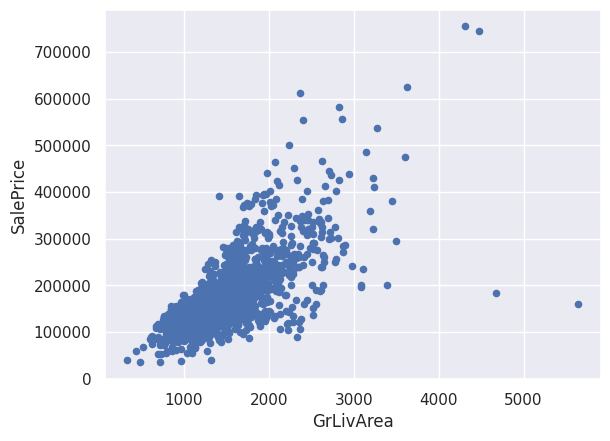

In [15]:
var = 'GrLivArea'
data = pd.concat([dataset_df['SalePrice'], dataset_df[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice')

In [16]:
dataset_df.sort_values(by='GrLivArea', ascending=False)[:2]['GrLivArea']

1298    5642
523     4676
Name: GrLivArea, dtype: int64

In [17]:
dataset_df.drop(labels=[1298, 523], axis=0, inplace=True)

<Axes: xlabel='TotalBsmtSF', ylabel='SalePrice'>

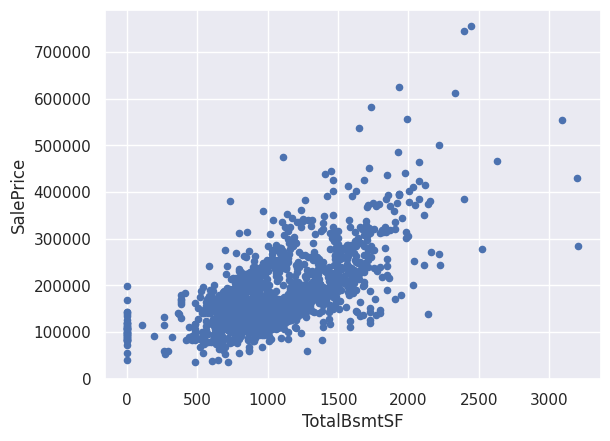

In [18]:
var = 'TotalBsmtSF'
data = pd.concat([dataset_df['SalePrice'], dataset_df[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice')

Далее проанализируем распределение тарегта и некоторых фич, чтобы воспользоваться Log-transform для того,
чтобы:
- нивелировать экстримальные выбросы;
- повысить обобщение данных;
- улучшить интерпретируемость фичей.

/tmp/ipykernel_10763/4171561346.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset_df['SalePrice'], fit=norm)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 640x480 with 0 Axes>

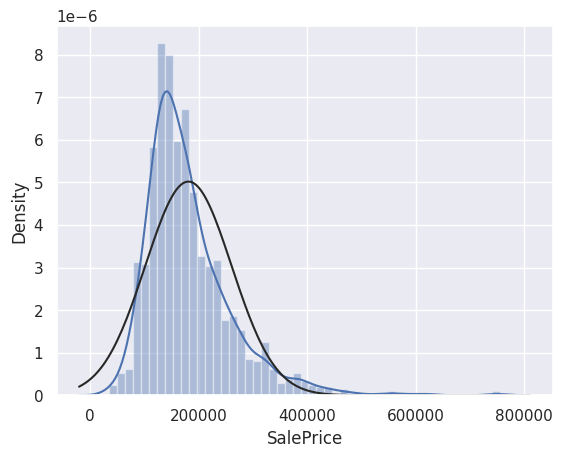

<Figure size 640x480 with 0 Axes>

In [19]:
from scipy.stats import norm

sns.distplot(dataset_df['SalePrice'], fit=norm)
fig = plt.figure()
fig

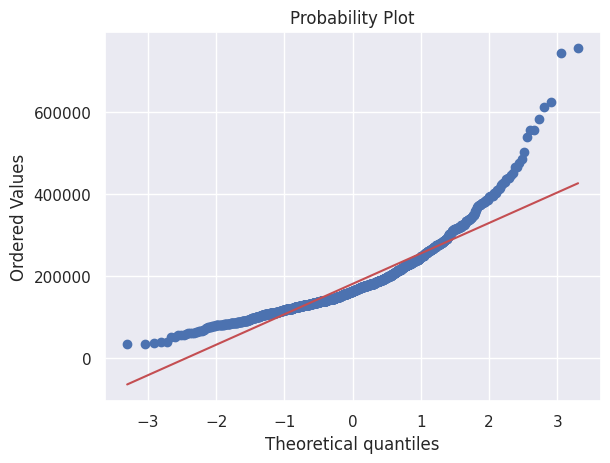

In [20]:
from scipy import stats

res = stats.probplot(dataset_df['SalePrice'], plot=plt)

In [21]:
dataset_df['SalePrice'] = np.log(dataset_df['SalePrice'])

/tmp/ipykernel_10763/1805999778.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset_df['SalePrice'], fit=norm)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 640x480 with 0 Axes>

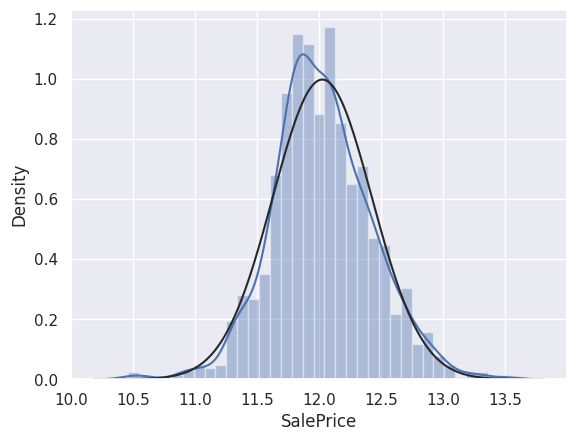

<Figure size 640x480 with 0 Axes>

In [22]:
sns.distplot(dataset_df['SalePrice'], fit=norm)
fig = plt.figure()
fig

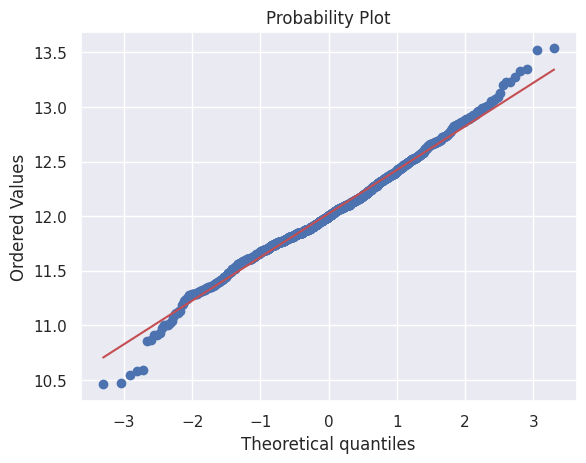

In [23]:
res = stats.probplot(dataset_df['SalePrice'], plot=plt)

/tmp/ipykernel_10763/805153112.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset_df['GrLivArea'], fit=norm);
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


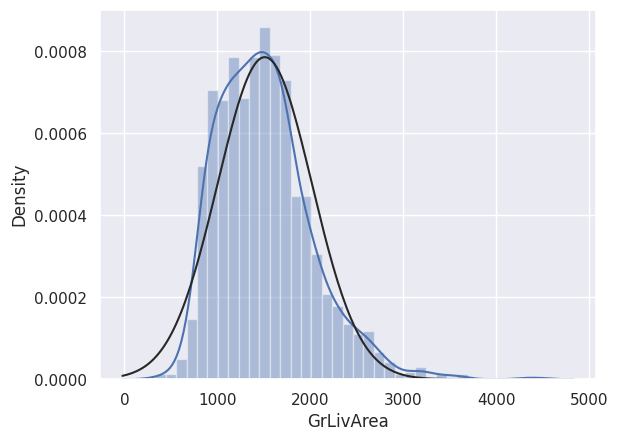

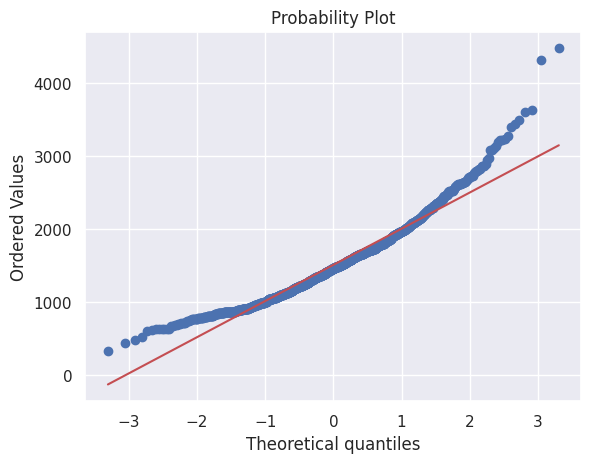

In [24]:
sns.distplot(dataset_df['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(dataset_df['GrLivArea'], plot=plt)

In [25]:
dataset_df['GrLivArea'] = np.log(dataset_df['GrLivArea'])

/tmp/ipykernel_10763/805153112.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset_df['GrLivArea'], fit=norm);
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


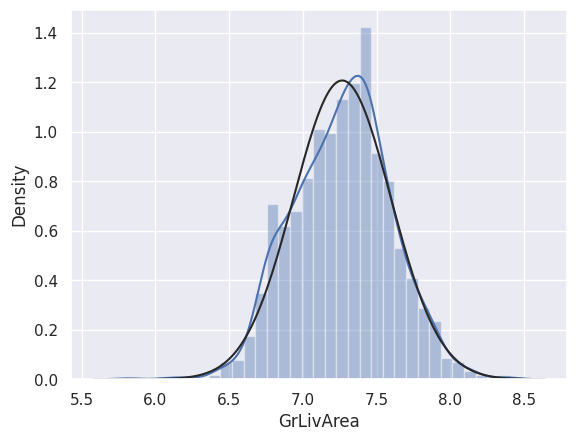

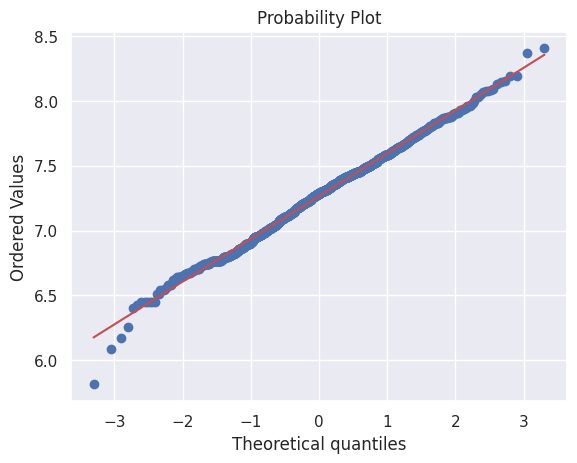

In [26]:
sns.distplot(dataset_df['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(dataset_df['GrLivArea'], plot=plt)

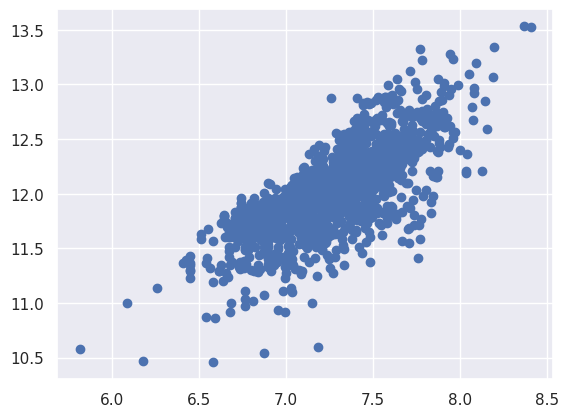

In [27]:
plt.scatter(dataset_df['GrLivArea'], dataset_df['SalePrice']);

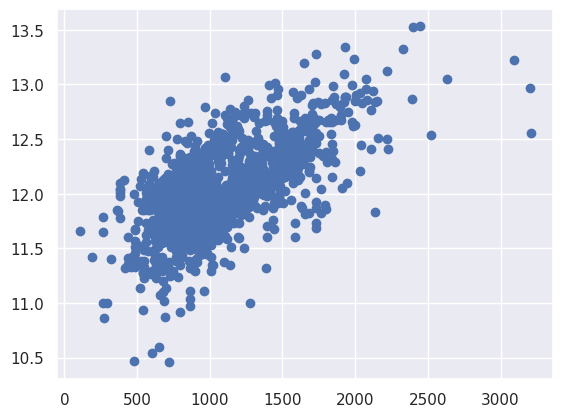

In [28]:
plt.scatter(dataset_df[dataset_df['TotalBsmtSF']>0]['TotalBsmtSF'], dataset_df[dataset_df['TotalBsmtSF']>0]['SalePrice']);

После всех проведенных действий создадим новое разбиение данных и создадим модель RandomForest с GridSearchCV для того, чтобы выбрать оптимальные параметры и получить лучшую модель.

In [29]:
new_train_ds_pd, new_valid_ds_pd = split_dataset(dataset_df)

target_label = 'SalePrice'

X_train = new_train_ds_pd[continuous_columns].drop(target_label, axis=1)
Y_train = new_train_ds_pd[target_label]
X_test = new_valid_ds_pd[continuous_columns].drop(target_label, axis=1)
Y_test = new_valid_ds_pd[target_label]

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline

In [31]:
model = RandomForestRegressor(random_state=42, n_jobs=-1)

param_grid = {
            'n_estimators': [200, 300, 400, 500, 600, 700],
            'max_depth': [None, 10, 20, 30, 40],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 5],
            'max_features': ['sqrt', 'log2', 0.5, 0.8],
            'bootstrap': [True, False]
        }


search = RandomizedSearchCV(
        model,
        param_grid, 
        n_iter=50,
        cv=5, 
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        random_state=42,
        verbose=1
    )

search

RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30, 40],
                                        'max_features': ['sqrt', 'log2', 0.5,
                                                         0.8],
                                        'min_samples_leaf': [1, 2, 5],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 300, 400, 500,
                                                         600, 700]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=1)

In [32]:
search.fit(X_train, Y_train)

best_model = search.best_estimator_

y_pred_train = best_model.predict(X_test)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [33]:
Y_test_real = np.exp(Y_test)
Y_prediction_real = np.exp(y_pred_train)
real_MAE = mean_absolute_error(Y_test_real, Y_prediction_real)
r2 = r2_score(Y_test_real, Y_prediction_real)
real_MedAE = median_absolute_error(Y_test_real, Y_prediction_real)
real_MAPE = mean_absolute_percentage_error(Y_test_real, Y_prediction_real)
print(real_MAE, r2, real_MedAE, real_MAPE)

15065.406737008821 0.906917007524672 8876.408221953432 0.0904531506953867


In [34]:
search.best_params_

{'n_estimators': 300,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': False}

Проверим, что гипер-параметры модели адекватные, и после этого проведем оценку по метрикам.

In [35]:
best_baseline_model = baseline_result['simple_linear']

print(f"Разница MAE: {real_MAE - best_baseline_model['MAE']}, Разница R2: {r2 - best_baseline_model['R2']}, Разница MedAE: {real_MedAE - best_baseline_model['MedAE']}, Разница MAPE: {real_MAPE - best_baseline_model['MAPE']}")

Разница MAE: -6938.827589106253, Разница R2: 0.16459380555496494, Разница MedAE: -5864.418542914907, Разница MAPE: -0.03588735533590942


Все значения метрик заметно стали лучше, это свидетельствует о том, что более сложная модель RandomForest гораздо лучше улавливает закономерности и тендеции в данных, снижает ошибки и даёт более корректные и правдоподобные значения, а самый лучший результат был достигнут в типичных ошибках (MedAE)

После оценки по метрикам проанализируем ошибки

In [36]:
errors = Y_test_real - Y_prediction_real
relative_errors = errors / Y_test_real

print(f"Средняя ошибка: ${errors.mean():.0f}")
print(f"Медианная ошибка: ${np.median(errors):.0f}")
print(f"Процент переоценок: {(errors < 0).mean():.1%}")
print(f"Процент недооценок: {(errors > 0).mean():.1%}")

large_errors_idx = np.abs(relative_errors) > 0.3
print(f"Крупные ошибки (>30%): {large_errors_idx.sum()} объектов")

Средняя ошибка: $2510
Медианная ошибка: $-39
Процент переоценок: 50.0%
Процент недооценок: 50.0%
Крупные ошибки (>30%): 11 объектов


In [37]:
importance_df = pd.DataFrame({'feature': X_train.columns,
                              'importance': best_model.feature_importances_
                             }).sort_values('importance', ascending=False)

top_5_features = importance_df.head(5)
print(top_5_features)

        feature  importance
2   OverallQual    0.176605
12    GrLivArea    0.140258
4     YearBuilt    0.111758
9   TotalBsmtSF    0.105920
20   GarageCars    0.068286


Также посмотрим на топ-5 фичей по важности и сгенерируем бизнес-инсайты:
1. Фокус на улучшении качества дома (OverallQual), т.к. это самый важный фактор, следовательно качество > площади, поэтому стоит инвестировать в ремонт и улучшение качества дома, а при продаже указывать качество отделки
2. Надземное пространство ценится выше подземного (GrLivArea): открытые планировки надземных этажей увеличивает воспринимаемую ценность, гараж это не просто парковка, а значительный актив.
3. Новое -> Дороже (YearBuilt): старые дома требуют значительной скидки, реновация старых домов может дать максимальный ROI, новостройки имеют премию к цене
4. Общая площадь подвала имеет значение и ценится покупателем (TotalBsmtSF), это дополнительный ценный ресурс, наличие которого может иметь значимость вне зависимости от ремонта и назначения.
5. Вместимость в местах для машин гораздо важнее абстрактной площади (GarageCars), гараж на 2 машины - стандарт ожиданий, каждое дополнительное место добавляет значительную стоимость.